In [1]:
file = "CarPrice_Assignment.csv"

Adding all the imports

In [2]:
%matplotlib inline

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# imports for data manipulation
import pandas as pd
import numpy as np

# imports for data visualization
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# importing stats model
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Preparation

In [3]:
# reading in the csv file
cars = pd.read_csv(file)

Splitting `Manufacturer` column

In [4]:
# Splitting car name into two cols and dropping it along with the ID col
cars['Manufacturer'] = cars.CarName.str.split().str[0]
# cars['Car'] = cars.CarName.str.split().str[1]

Removing all unnecessary columns

In [5]:
# dropping cols not required
cars.drop(['car_ID', 'CarName'], axis='columns', inplace=True)

Converting `cylindernumber` column as ordinal

In [6]:
# changing 'cylindernumber' to numerical
cars['cylindernumber'] = cars['cylindernumber'].map({'four': 4, 'six': 6, 'five': 5, 
                            'three': 3, 'twelve': 12, 'two': 2, 
                            'eight': 8})

Correcting all the spelling mistakes

In [7]:
# 'Manufacturer' column correcting the spelling mistakes
cars['Manufacturer'] = cars['Manufacturer'].replace({'maxda': 'mazda', 'toyouta': 'toyota',
                             'Nissan': 'nissan', 'porcshce': 'porsche',
                             'vokswagen': 'volkswagen'})

Bucketing the `Manufacturer` as ordinal variable based on the how premium a brand is, this is done to aid interpretability over high r2

In [8]:
def switch(x):
    if x == 'chevrolet':
        return 0
    elif x in ['dodge', 'plymouth', 'honda', 
             'subaru', 'isuzu', 'mitsubishi', 'renault', 
             'toyota', 'volkswagen', 'nissan', 'mazda', 'vw']:
        return 1
    elif x in ['saab', 'peugeot', 'alfa-romero', 'mercury',
                 'audi', 'volvo']:
        return 2
    elif x == 'bmw':
        return 3
    elif x in ['porsche', 'buick', 'jaguar']:
        return 4
    else:
        raise Exception('car brand not found %s' % (x))
        
cars['Manufacturer'] = cars['Manufacturer'].transform(switch)

# Data Exploration

In [9]:
# Inspecting first few rows
cars.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,Manufacturer
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0,2
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0,2
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0,2
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0,2
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0,2


In [10]:
# inspecting the distribution of numerical values
cars.describe()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,Manufacturer
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,4.380488,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571,1.487805
std,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,1.080854,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332,0.910773
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,2.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000,0.000000
25%,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,4.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000,1.000000
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,4.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000,1.000000
75%,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,4.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000,2.000000
max,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,12.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000,4.000000


In [11]:
# no null entries in the dataset
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 25 columns):
symboling           205 non-null int64
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null int64
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm             205 non-null int64
citympg             205 non-null int64
highwaympg     

In [12]:
# storing categorical column names in a list
categorical_cols = cars.columns[cars.dtypes == 'object']

# storing numerical column names in a list
numerical_cols = cars.columns[(cars.dtypes == 'int64') | (cars.dtypes == 'float64')]

Plotting all the numeric column vs `price`

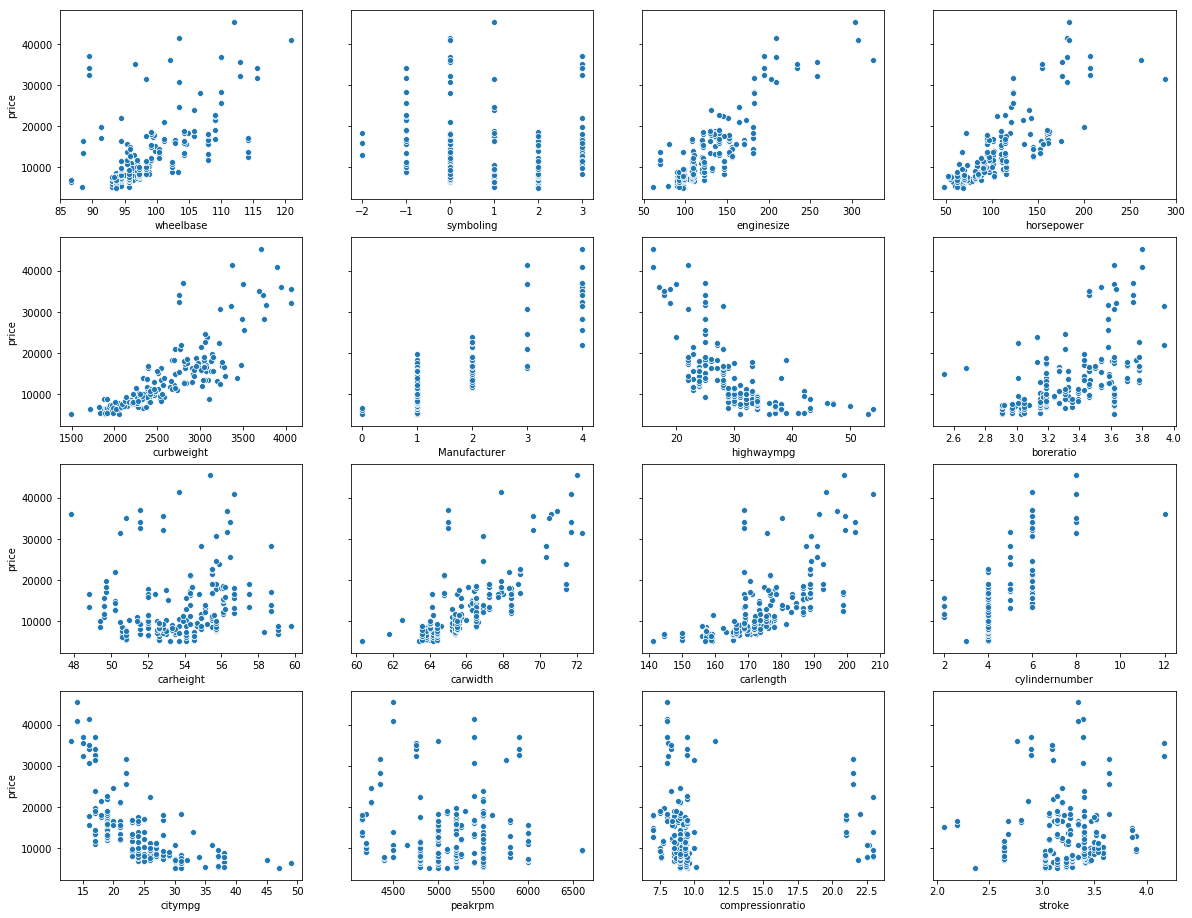

In [13]:
# scatter plots for numerical values
def plot_scatter(ax, x, y):
    sns.scatterplot(x, y, data=cars, ax=ax)
    
# selecting req numerical cols
cols = list(set(numerical_cols) - set(["price"]))

# creating subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16), sharey=True)
aa = [ax for row in axes for ax in row]

# plotting subplots iteratively
for i, c in enumerate(cols):
    plot_scatter(aa[i], c, 'price')

plt.show()

In [14]:
# inspecting the categorical cols
cars[categorical_cols].describe()

,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,fuelsystem
count,205,205,205,205,205,205,205,205
unique,2,2,2,5,3,2,7,8
top,gas,std,four,sedan,fwd,front,ohc,mpfi
freq,185,168,115,96,120,202,148,94


Plotting boxplots for the categorical columns

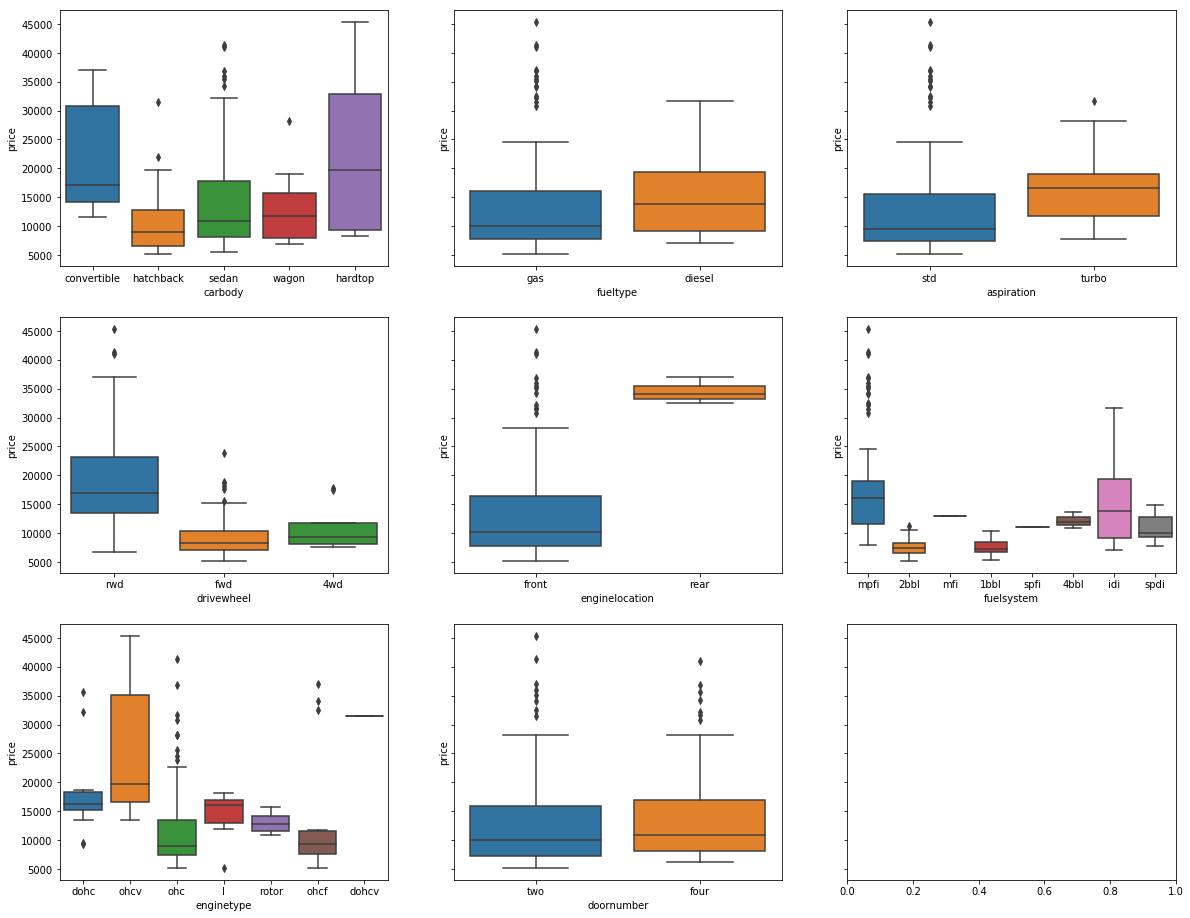

In [15]:
# box plots for categorical values
def plot_boxplot(ax, x, y):
    sns.boxplot(x, y, data=cars, ax=ax)

# selecting req categorical cols
# cols = list(set(categorical_cols) - set(["Manufacturer"]))
cols = list(set(categorical_cols) - set([]))

# creating subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 16), sharey=True)
aa = [ax for row in axes for ax in row]

# plotting subplots iteratively
for i, c in enumerate(cols):
    plot_boxplot(aa[i], c, 'price')

plt.show()

# Dummy Columns Creation

In [16]:
# creating dummy cols for categorical variables
cars_dummies = pd.get_dummies(cars, columns=categorical_cols, drop_first=True, sparse=True)

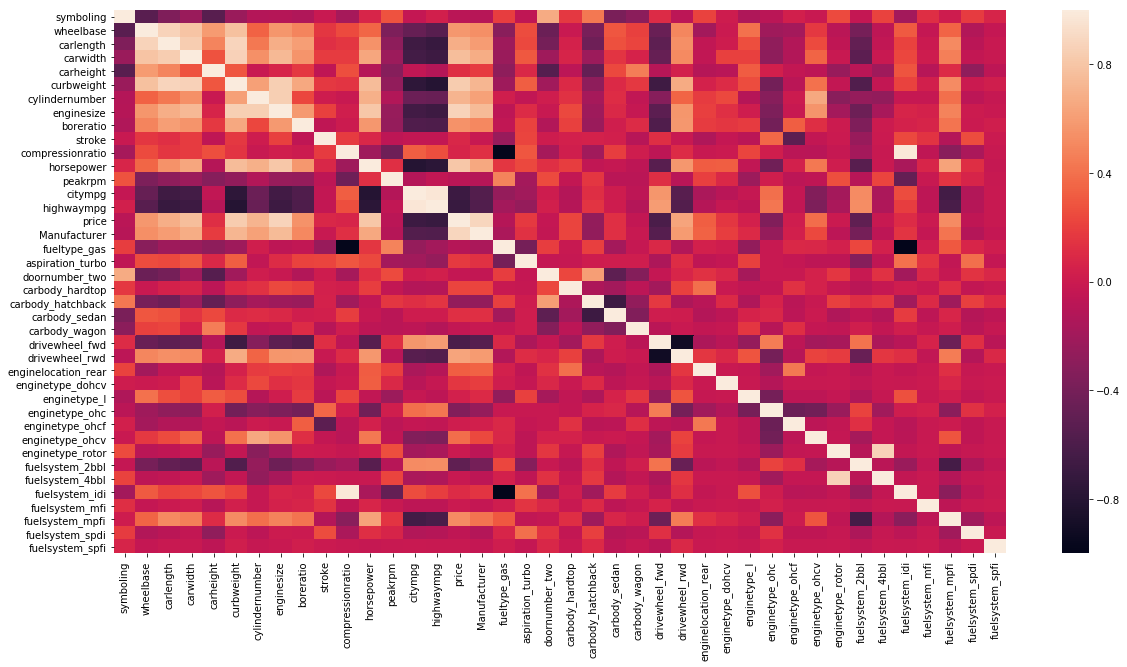

In [17]:
plt.figure(figsize = (20,10))
sns.heatmap(cars_dummies.corr(),annot = False)
plt.show()

# Test-Train Split

In [18]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
cars_train, cars_test = train_test_split(cars_dummies, train_size = 0.7, test_size = 0.3, random_state = 100)

# Scaling

In [19]:
# Apply scaler() to all the columns except the 'dummy' variables
scaler = MinMaxScaler()
cars_train[numerical_cols] = scaler.fit_transform(cars_train[numerical_cols])

/home/vasanthakumar/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# RFE

## Dividing into X and Y for model building

In [20]:
y_train = cars_train.pop('price')
X_train = cars_train

## Fitting the Model

Calculating `r2_adj` for different values of n using `RFE` and storing the results

In [21]:
def lm_with_n(lm, no_of_cols):
    # Running RFE with the output number of the variable equal to 10
    lm.fit(X_train, y_train)

    # running RFE
    rfe = RFE(lm, no_of_cols)
    rfe = rfe.fit(X_train, y_train)

    col = X_train.columns[rfe.support_]

    # Creating X_test dataframe with RFE selected variables
    X_train_rfe = X_train[col]

    # Adding a constant variable 
    X_train_rfe = sm.add_constant(X_train_rfe)

    # Running the linear model
    lm = sm.OLS(y_train,X_train_rfe).fit()

    # print(lm.summary())
    return round(lm.rsquared_adj, 4)

lm = LinearRegression()
r2 = []
x = []
for n in range(1, len(X_train.columns)):
    x.append(n)
    r2.append(lm_with_n(lm, n))

Plotting the results of the above function

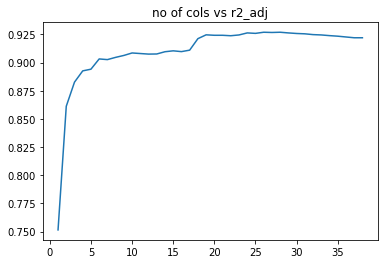

no of cols 26, has high r2_adj of 0.9270


In [22]:
# plotting cols vs r2_adj
plt.plot(x, r2)
plt.title("no of cols vs r2_adj")
plt.show()

i = r2.index(max(r2))
print("no of cols %d, has high r2_adj of %.4f" % (x[i], r2[i]))

In [23]:
# Running RFE with the output number of the variable equal to n which gives the highest r2_adj
lm = LinearRegression()
lm.fit(X_train, y_train)

# running RFE
rfe = RFE(lm, x[i])
rfe = rfe.fit(X_train, y_train)

In [24]:
col = X_train.columns[rfe.support_]
col

Index(['wheelbase', 'carlength', 'carwidth', 'curbweight', 'cylindernumber',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'Manufacturer', 'fueltype_gas',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_rwd', 'enginelocation_rear',
       'enginetype_ohc', 'enginetype_ohcf', 'enginetype_rotor',
       'fuelsystem_idi', 'fuelsystem_spdi'],
      dtype='object')

In [25]:
X_train.columns[~rfe.support_]

Index(['symboling', 'carheight', 'aspiration_turbo', 'doornumber_two',
       'drivewheel_fwd', 'enginetype_dohcv', 'enginetype_l', 'enginetype_ohcv',
       'fuelsystem_2bbl', 'fuelsystem_4bbl', 'fuelsystem_mfi',
       'fuelsystem_mpfi', 'fuelsystem_spfi'],
      dtype='object')

# Building a Regression Model

In [26]:
def lm_and_vif(cols_to_remove=[], vif=True):
    # removing cols for experimenting with new models
    cols_for_model = list(set(col) - set(cols_to_remove))
    
    # Creating X_test dataframe with RFE selected variables
    X_train_rfe = X_train[cols_for_model]

    # Adding a constant variable 
    X_train_rfe = sm.add_constant(X_train_rfe)

    # Running the linear model
    lm = sm.OLS(y_train,X_train_rfe).fit()

    # printing result to screen
    print(lm.summary())

    if vif:
        # Calculate the VIFs for the new model
        vif = pd.DataFrame()
        X = X_train_rfe.drop('const', axis='columns')
        vif['Features'] = X.columns
        vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif['VIF'] = round(vif['VIF'], 5)
        pvalues = lm.pvalues.reset_index()
        pvalues.columns = ['features', 'pvalues']
        pvalues = pd.merge(pvalues, vif, left_on='features', right_on='Features')
        pvalues.drop("Features", inplace=True, axis="columns")
        pvalues = pvalues.sort_values(by = "VIF", ascending = False)
        pvalues['pvalues'] = round(pvalues['pvalues'], 3)

        # printing result to screen
        print("\t\tVIF and pvalues")
        print("========================================")
        print(pvalues)
    
    return (lm, X_train_rfe, cols_for_model)

In [27]:
model, X_train_model, cols_for_model = lm_and_vif()

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     73.13
Date:                Sun, 24 Feb 2019   Prob (F-statistic):           9.23e-60
Time:                        18:44:16   Log-Likelihood:                 217.93
No. Observations:                 143   AIC:                            -383.9
Df Residuals:                     117   BIC:                            -306.8
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0483    

Eliminating a column which has high VIF and insignificant

In [28]:
model, X_train_model, cols_for_model = lm_and_vif(['fuelsystem_idi'], vif=False)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     73.13
Date:                Sun, 24 Feb 2019   Prob (F-statistic):           9.23e-60
Time:                        18:44:16   Log-Likelihood:                 217.93
No. Observations:                 143   AIC:                            -383.9
Df Residuals:                     117   BIC:                            -306.8
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2504    

After repeating the process of elimination arriving at the final list *(codes skipped for brevity of the notebook)*

In [29]:
model, X_train_model, cols_for_model = lm_and_vif(['fuelsystem_idi', 'highwaympg', 'fueltype_gas', 'cylindernumber',
                                                  'curbweight', 'carlength', 'carwidth', 'boreratio',
                                                  'stroke', 'compressionratio', 'wheelbase', 'citympg',
                                                  'horsepower', 'carbody_sedan', 'carbody_hatchback',
                                                  'peakrpm', 'enginetype_ohc', 'carbody_wagon', 'drivewheel_rwd',
                                                  'enginetype_ohcf', 'enginetype_rotor', 'carbody_hardtop',
                                                  'enginelocation_rear', 'fuelsystem_spdi'], vif=False)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     442.1
Date:                Sun, 24 Feb 2019   Prob (F-statistic):           3.19e-61
Time:                        18:44:16   Log-Likelihood:                 159.23
No. Observations:                 143   AIC:                            -312.5
Df Residuals:                     140   BIC:                            -303.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1184      0.013     -8.970   

## Interpreting the Model

`enginesize` is a variable that can be proxy for the horsepower, stroke and lot other variables, this has a positive coefficient and `Manufacturer` brand plays a major role for setting the price

# Residual Analysis

Text(0.5, 0, 'Errors')

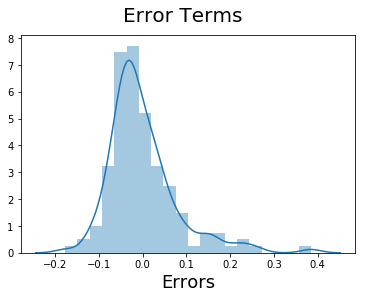

In [30]:
y_train_price = model.predict(X_train_model)

# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)
plt.xlabel('Errors', fontsize = 18) 

# Model Evaluation

In [31]:
# Scaling the test set with scaler from the training set
cars_test[numerical_cols] = scaler.transform(cars_test[numerical_cols])

# Creating X and Y variables
y_test = cars_test.pop('price')
X_test = cars_test

# Now let's use our model to make predictions.
# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[cols_for_model]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

# Making predictions
y_pred = model.predict(X_test_new)

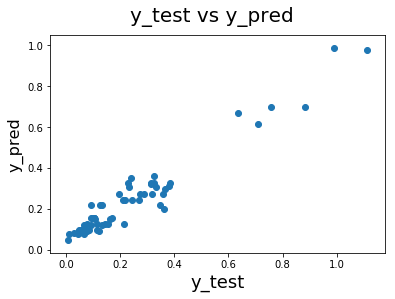

In [32]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20) 
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)
plt.show()